# Trabalho de conclusão de curso - Data Science com ênfase em Machine Learning
## Alunos: Douglas Tadeu Sabatini & Jari Fernandes Nogueira Neto


### FIB Bauru - 06/2020

### Instruções.
 A captura dos caracteres, foi elaborada para um padrão específico, não funcionando com qualquer imagem, por isso a função crop_ok() para validar a imagem.

 A rede foi treinada para reconhecer os caracteres no padrão antigo de placas do DETRAN. Placas do mercosul não funcionam.
 
 
 - Após carregar bibliotecas, rodar as funções ao fim do código;
 - Carregar os modelos e pesos que serão utilizados;
 - Validar localização dos caracteres com a função crop_ok('caminho_da_imagem');
 - Com uma imagem válida, aplicar a função plate_detector('caminho_da_imagem').

 *OBS: O processo plate_detector(), pode demorar cerca de 30 à 120 segundos para processamento.

In [1]:
import numpy as np
import cv2
import imutils
from PIL import Image

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models
from keras.models import model_from_json

import keras

Using TensorFlow backend.


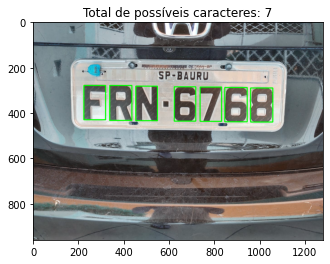

In [4]:
# Valida a detecção dos caracteres, para processamento.
image = cv2.imread('/content/3.jpeg')
crop_ok(image)

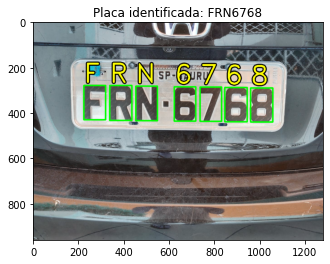

In [0]:
# Processa a imagem e sugere quais caracteres compõe a placa.
plate_detector('/content/3.jpeg')

# Carregando modelos para Letras e Números.

In [0]:
# Carrega o arquivo JSON e recriando o modelo de letras.
json_file = open('/content/models_colab/model_char_100-1.json', 'r') # Modelo para letras.
loaded_model_char_json = json_file.read()
json_file.close()
model_char = model_from_json(loaded_model_char_json)
model_char.load_weights("/content/models_colab/model_char_100-1.h5") # Carrega os pesos e adiciona ao modelo.
print("Modelo - char - carregado.")


# Carregando segundo JSON e recriando o modelo de números.
json_file = open('/content/models_colab/model_num_100-1.json', 'r') # Modelo para números.
loaded_model_num_json = json_file.read()
json_file.close()
model_num = model_from_json(loaded_model_num_json)
model_num.load_weights("/content/models_colab/model_num_100-1.h5") # Carrega os pesos e adiciona ao modelo.
print("Modelo - num - carregado.")



#Compilando modelos:
# Letras:
model_char.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
# Números:
model_num.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

Modelo - char - carregado.
Modelo - num - carregado.


# Criando funções, para processar as imagens.

Tratam-se de 3 funções distintas:
- crop_ok: Utilizado para validar imagem para procssamento. Retorna a imagem com os prováveis caracteres detectados na imagem;
- zhangSuen: Função para criação do esqueleto de Zhang Suen nos caracteres mapeados;
- plate_detector: Processa imagem apta, aplica os modelos para identificar os caracteres e plota a imagem com o que foi mapeado pela rede.

In [0]:
# Criando função para o esqueleto de Zhang Suen.

def neighbours(image, x, y):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    neigh = [img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],
             img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1]] 
    return neigh  

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    skeleton = image.copy()  # deepcopy to protect the original image
    skeleton = cv2.divide(skeleton, 255)
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = skeleton.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2, P3, P4, P5, P6, P7, P8, P9 = n = neighbours(skeleton, x, y)
                if (skeleton[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0): # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            skeleton[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(skeleton, x, y)
                if (skeleton[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0): # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            skeleton[x][y] = 0

    skeleton = cv2.multiply(skeleton, 255)
    return skeleton

In [0]:
def crop_ok(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    smooth = cv2.bilateralFilter(gray, 15, 50, 50)
    ret3,th = cv2.threshold(smooth,0,255,cv2.THRESH_TRUNC + cv2.THRESH_OTSU)
    _, bin_1 = cv2.threshold(th, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    neg_img = cv2.bitwise_not(bin_1) ## 1- trunc, 2 - tozero.
    kernel = np.ones((3,3),np.uint8)
    closing = cv2.morphologyEx(neg_img, cv2.MORPH_CLOSE, kernel)

    edged = cv2.Canny(closing, 100, 200)
    cnts, new  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)
    boxes = [cv2.boundingRect(c) for c in cnts_sorted]

    tempboxes = []
    tempboxes_2 = []
    finalboxes = []
    med_h = []
    med_x = []
    i=0

    for i in range(len(boxes)):
        ref = boxes[i][3]/boxes[i][2]    
    
        if 1.3 < ref < 5.5:
            ref2 = boxes[i][3]-boxes[i][2]
            if 20 < ref2:
                tempboxes.append(boxes[i])
                med_h.append(boxes[i][3])
            
        i+1

    j = 0
    k = 0
    m = np.median(med_h)


    for j in range(len(tempboxes)):
        if m*0.8 < tempboxes[j][3] < m*1.2:
            tempboxes_2.append(tempboxes[j])
            med_x.append(tempboxes[j][1])
        
    p = np.median(med_x)
        
    for k in range(len(tempboxes_2)):
        if p*0.95 < tempboxes_2[k][1] < p*1.05:
            finalboxes.append(tempboxes_2[k])
            
### PONTO B:            
    
    if len(finalboxes) < 7:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        smooth = cv2.bilateralFilter(gray, 15, 50, 50)
        ret3,th = cv2.threshold(smooth,0,255,cv2.THRESH_TOZERO + cv2.THRESH_OTSU)
        _, bin_1 = cv2.threshold(th, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        neg_img = cv2.bitwise_not(bin_1)
        kernel = np.ones((3,3),np.uint8)
        closing = cv2.morphologyEx(neg_img, cv2.MORPH_CLOSE, kernel)

        edged = cv2.Canny(closing, 100, 200)
        cnts, new  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


        cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)
        boxes = [cv2.boundingRect(c) for c in cnts_sorted]

        tempboxes = []
        tempboxes_2 = []
        finalboxes = []
        med_h = []
        med_x = []
        i=0

        for i in range(len(boxes)):
            ref = boxes[i][3]/boxes[i][2]    

            if 1.3 < ref < 5.5:
                ref2 = boxes[i][3]-boxes[i][2]
                if 20 < ref2:
                    tempboxes.append(boxes[i])
                    med_h.append(boxes[i][3])

            i+1

        j = 0
        k = 0
        m = np.median(med_h)


        for j in range(len(tempboxes)):
            if m*0.8 < tempboxes[j][3] < m*1.2:
                tempboxes_2.append(tempboxes[j])
                med_x.append(tempboxes[j][1])

        p = np.median(med_x)

        for k in range(len(tempboxes_2)):
            if p*0.95 < tempboxes_2[k][1] < p*1.05:
                finalboxes.append(tempboxes_2[k])
       
    
    img_f = image
    l = 0
    
    for l in range(len(finalboxes)):
        x, y, w, h = finalboxes[l]
        cv2.rectangle(img_f,(x,y),(x+w,y+h),(0,255,0),4)
        l+1
    
    tit = 'Total de possíveis caracteres: ' + str(len(finalboxes))
    plt.imshow(img_f)
    plt.title(tit)
    plt.show()

In [0]:
def plate_detector(path):
    
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    smooth = cv2.bilateralFilter(gray, 15, 50, 50)
    ret3,th = cv2.threshold(smooth,0,255,cv2.THRESH_TRUNC + cv2.THRESH_OTSU)
    _, bin_1 = cv2.threshold(th, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    neg_img = cv2.bitwise_not(bin_1) ## 1- trunc, 2 - tozero.
    kernel = np.ones((3,3),np.uint8)
    closing = cv2.morphologyEx(neg_img, cv2.MORPH_CLOSE, kernel)

    edged = cv2.Canny(closing, 100, 200)
    cnts, new  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)
    boxes = [cv2.boundingRect(c) for c in cnts_sorted]

    tempboxes = []
    tempboxes_2 = []
    finalboxes = []
    med_h = []
    med_x = []
    i=0

    for i in range(len(boxes)):
        ref = boxes[i][3]/boxes[i][2]    
    
        if 1.3 < ref < 5.5:
            ref2 = boxes[i][3]-boxes[i][2]
            if 20 < ref2:
                tempboxes.append(boxes[i])
                med_h.append(boxes[i][3])
            
        i+1

    j = 0
    k = 0
    m = np.median(med_h)


    for j in range(len(tempboxes)):
        if m*0.8 < tempboxes[j][3] < m*1.2:
            tempboxes_2.append(tempboxes[j])
            med_x.append(tempboxes[j][1])
        
    p = np.median(med_x)
        
    for k in range(len(tempboxes_2)):
        if p*0.95 < tempboxes_2[k][1] < p*1.05:
            finalboxes.append(tempboxes_2[k])
            
### PONTO B:            
    
    if len(finalboxes) < 7:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        smooth = cv2.bilateralFilter(gray, 15, 50, 50)
        ret3,th = cv2.threshold(smooth,0,255,cv2.THRESH_TOZERO + cv2.THRESH_OTSU)
        _, bin_1 = cv2.threshold(th, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        neg_img = cv2.bitwise_not(bin_1)
        kernel = np.ones((3,3),np.uint8)
        closing = cv2.morphologyEx(neg_img, cv2.MORPH_CLOSE, kernel)

        edged = cv2.Canny(closing, 100, 200)
        cnts, new  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


        cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)
        boxes = [cv2.boundingRect(c) for c in cnts_sorted]

        tempboxes = []
        tempboxes_2 = []
        finalboxes = []
        med_h = []
        med_x = []
        i=0

        for i in range(len(boxes)):
            ref = boxes[i][3]/boxes[i][2]    

            if 1.3 < ref < 5.5:
                ref2 = boxes[i][3]-boxes[i][2]
                if 20 < ref2:
                    tempboxes.append(boxes[i])
                    med_h.append(boxes[i][3])

            i+1

        j = 0
        k = 0
        m = np.median(med_h)


        for j in range(len(tempboxes)):
            if m*0.8 < tempboxes[j][3] < m*1.2:
                tempboxes_2.append(tempboxes[j])
                med_x.append(tempboxes[j][1])

        p = np.median(med_x)

        for k in range(len(tempboxes_2)):
            if p*0.95 < tempboxes_2[k][1] < p*1.05:
                finalboxes.append(tempboxes_2[k])
       
    
    bd_img = []
    i = 0

    finalboxes = sorted(finalboxes, key=lambda tup: tup[0])

    for i in range(0,7):
        x, y, w, h = finalboxes[i]   

        w1 = int(round((x*0.99), 0))
        w2 = int(round((w*1.22), 0))
        h1 = int(round((y*0.965), 0))
        h2 = int(round((h*1.18), 0))

        if finalboxes[i][3]/finalboxes[i][2] > 2.5:
            w1 = int(round((x*0.96), 0))
            w2 = int(round((w*2.75), 0))

        new_img = gray[h1:h1 + h2, w1:w1 + w2] # Aumento de 21% no comprimento e de 18% na altura.
        bd_img.append(new_img)


    new_width = 170
    new_height = 240

    bd_skull = []
    images_to_generate = len(bd_img) # Mapeia a quantidade de arquivos que serão tratados.

    i=0

    while i < images_to_generate:

        original_image = bd_img[i]

        neg_img = cv2.bitwise_not(original_image)
        blur = cv2.GaussianBlur(neg_img,(5,5),1)
        ret3,th = cv2.threshold(blur,0,255,cv2.THRESH_TOZERO + cv2.THRESH_OTSU)

        cnts, new  = cv2.findContours(th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts_sorted = sorted(cnts, key = cv2.contourArea, reverse = True)

        idx = 0 # Índice do contorno que será recortado (maior contorno)
        mask = np.zeros_like(th) # cria máscara para o recorte.
        cv2.drawContours(mask, cnts_sorted, idx, 255, -1) # Desenha o contorno na máscara, preenchido.

        out = np.zeros_like(th) # Extrai o contorno.
        out[mask == 255] = th[mask == 255]    

        (y, x) = np.where(mask == 255)
        (topy, topx) = (np.min(y), np.min(x))
        (bottomy, bottomx) = (np.max(y), np.max(x))
        out = out[topy:bottomy+1, topx:bottomx+1]    

        out_rgb = cv2.cvtColor(out,cv2.COLOR_GRAY2RGB) # Retorna para 3 canais, para converter em imagem.

        new_img = Image.fromarray(out_rgb, 'RGB') # Converte para imagem.

        width, height = new_img.size   # Captura dimensões do recorte.

        left = (width - new_width)/2
        top = (height - new_height)/2
        right = (width + new_width)/2
        bottom = (height + new_height)/2


        im_ok = new_img.crop((left, top, right, bottom))

        img_np = np.array(im_ok)
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)

        _, bin1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = np.ones((7,7),np.uint8)
        closing = cv2.morphologyEx(bin1, cv2.MORPH_CLOSE, kernel)

        img_esq = zhangSuen(closing)

        bd_skull.append(img_esq)

        i = i+1
    
    # Criando dicionário para categorizar numéricamente os rótulos das letras.
    dic_nc = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 
              10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
              19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}



    x_char = []
    x_num = []


    # Populando a lista x com as imagens e rotulando na lista y.
    # Inserindo também as informações na base final (para envio das informações).


    for i in range(3):
        x_char.append(bd_skull[i]) # Agregando a imagem de letra na lista x_char.

    for i in range(3, 7):
        x_num.append(bd_skull[i]) # Agregando a imagem de números na lista x_num.


    # Ajustando dimensões para a rede.
    x_char = np.expand_dims(x_char, -1)
    x_num = np.expand_dims(x_num, -1)

    # Aplicando modelo, aos recortes.
    char_pred = model_char.predict(x_char) 
    char_ok = char_pred.argmax(axis=-1)
    char_ok = [dic_nc[letter] for letter in char_ok]

    num_pred = model_num.predict(x_num)
    num_ok = num_pred.argmax(axis=-1)

    # Definindo a placa, pela predição dos modelos.
    placa = [y for x in [char_ok, num_ok] for y in x]
    placa_str = ''.join(map(str, placa))

    img_f = image
    i=0

    # Plotando caixa nos caracteres.
    for i in range(len(finalboxes)):
        x, y, w, h = finalboxes[i]
        cv2.rectangle(img_f,(x,y),(x+w,y+h),(0,255,0),6)
        i+1
    
    # Plotando predição do modelo, acima das bounding boxes.
    for i in range(len(placa)):
        pos_x = int(finalboxes[i][0])
        pos_y = int(finalboxes[i][1]*0.95)
        position = (pos_x, pos_y)

        # Plotando caracteres em tamanhos e cores diferentes, para facilitar leitura.
        cv2.putText(img_f, str(placa[i]) ,position, cv2.FONT_HERSHEY_DUPLEX, 4, (0, 0, 0), 13)
        cv2.putText(img_f, str(placa[i]) ,position, cv2.FONT_HERSHEY_DUPLEX, 4, (255, 255, 0), 3)    


    plt.imshow(img_f)
    plt.title('Placa identificada: ' + str(placa_str))
    plt.show()